# Unsupervised Anomaly Detection on fastMRI

In [24]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml

from trainer.trainer import AutoencoderModel
from data_loader import TrainDataModule

# autoreload imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the config

In [23]:
with open('./configs/autoencoder_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config['seed'])

Global seed set to 42


42

## Load and visualize the data

Found 582 files in ./data/IXI/


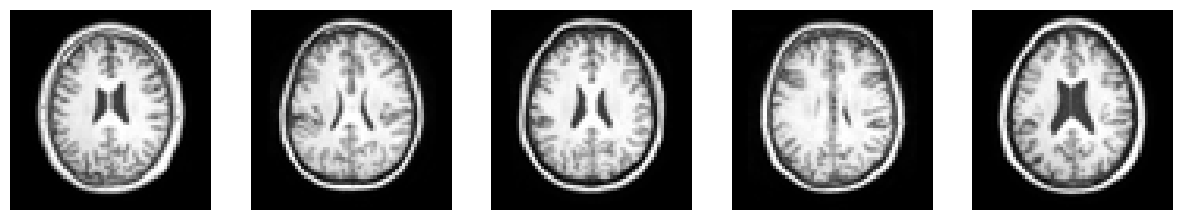

In [18]:
train_data_module = TrainDataModule(
    data_dir=config['train_data_dir'],
    target_size=config['target_size'],
    batch_size=config['batch_size'])

# Plot some images
batch = next(iter(train_data_module.train_dataloader()))

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(batch[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

## Prepare model

In [19]:
# Init model
model = AutoencoderModel(config)

max_epochs = config['num_epochs']
trainer = pl.Trainer(max_epochs=max_epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Run training

In [20]:
# Train the model
trainer.fit(model, datamodule=train_data_module)

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 387 K 
1 | decoder | Sequential | 387 K 
---------------------------------------
775 K     Trainable params
0         Non-trainable params
775 K     Total params
3.102     Total estimated model params size (MB)


{'data_dir': './data/IXI/', 'target_size': [64, 64], 'seed': 42, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 32}
Epoch 99: 100%|██████████| 15/15 [00:00<00:00, 37.96it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 15/15 [00:00<00:00, 36.51it/s, v_num=3]


## Evaluation

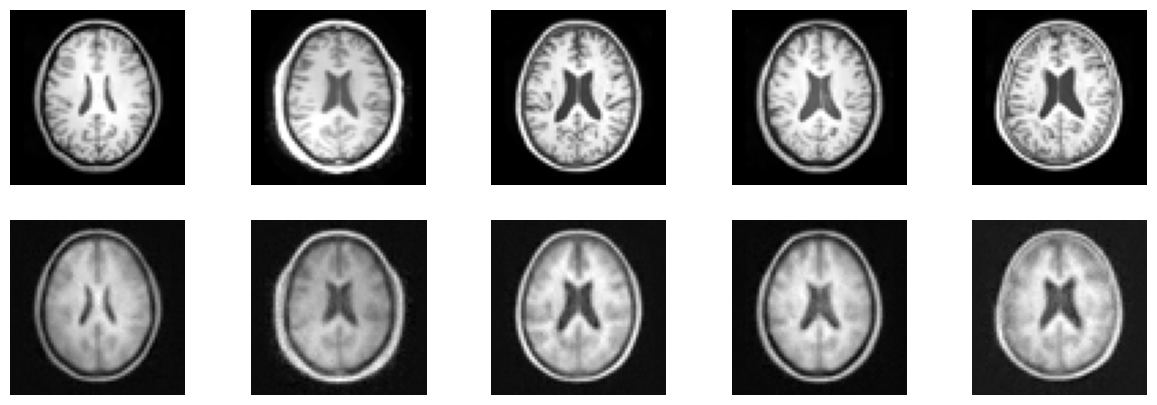

In [21]:
batch = next(iter(train_data_module.train_dataloader()))

with torch.inference_mode():
    results = model.detect_anomaly(batch)
    reconstructions = results['reconstruction']

# Plot images and reconstructions
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    ax[0][i].imshow(batch[i].squeeze(), cmap='gray')
    ax[0][i].axis('off')
    ax[1][i].imshow(reconstructions[i].squeeze(), cmap='gray')
    ax[1][i].axis('off')

In [36]:
from data_loader import get_all_test_dataloaders

test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])

In [37]:
test_dataloaders

{'absent_septum': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c697970>,
 'artefacts': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c697130>,
 'craniatomy': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c697220>,
 'dural': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c6972b0>,
 'ea_mass': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c696f20>,
 'edema': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c6975e0>,
 'encephalomalacia': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c697850>,
 'enlarged_ventricles': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c697670>,
 'intraventricular': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c697a00>,
 'lesions': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c697b50>,
 'mass': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c697d00>,
 'posttreatment': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c697eb0>,
 'resection': <torch.utils.data.dataloader.DataLoader at 0x7f3f6c696da0>,
 'sinus': <torch.utils

In [38]:
batch = next(iter(test_dataloaders['absent_septum']))